In [1]:
import requests
import json
import sys
import matplotlib.pyplot as plt
from matplotlib.dates import drange
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import time
import statsmodels.api as sm
import matplotlib.dates as mdates
from patsy import dmatrices

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Introduction

Many people play video games, but there is a growing community of people who enjoy an extra challenge: finishing the game as fast as possible. For practically every game, there is a speedrunning scene. In the early days of speedrunning, the practice was incredibly niche and splintered on various websites. But over the past 2 decades Speedrunning.com has become the biggest congregation of speedrunning content on the internet. The top players of my speedrunning scene, Minecraft: Java Edition, have noted how the number of players/runs during quarantine has exploded, to the point where moderation became backlogged. So I wanted to download data from the website and see if this quarantine effect was real, and if so was it the only variable involved?

# Collecting the data

Thankfully, Speedrun.com provides a rest API for us to pull information about games, leaderboards, and even individual runs. The API requires a header that briefly describes the use, which we do here:

In [2]:
init_headers = {'User-Agent': 'uni-project-bot/1.0'}

Now we can pull every game that is on Speedrun.com. We can request the IDs of games, which are used to uniquely identify them, and are useful for gaining more important information later. 

In [3]:
game_IDs = []
offset = 0
# Request every game in batches of 1000
while(True):
    # Request and unpack 1000 games
    URL = 'https://www.speedrun.com/api/v1/games?_bulk=yes&max=1000&offset=' + str(offset)
    response = requests.get(URL, init_headers)
    data = response.json()['data']
    # Add each game to array
    for game in data:
        game_IDs.append(game['id'])
    offset += 1000
    # If length is less than max, we break
    if len(data) < 1000:
        break
print(len(game_IDs))

28755


We see that in all, there are over 28 thousand games on Speedrun.com! With the IDs we can now pull and store all the data we need. Here is the dataframe we will use, and we collect data in the following categories:

* Game: This is the international name of the game

* Category: The category of the speedrun, which defines the leaderboard. A game can have multiple types of speedruns, such as beating the full game vs. a signle level, and the category differentiates these types. It can be split into further subcategories with the values.

* Run Time: The length of the speedrun, defined as whatever time is used for rankings on the leaderboard

* Date: The date the speedrun was submitted (not always present)

* Values: Set of aspects of a run that can put it in a subcategory, such as using glitches vs. glitchless. Only present if it creates a subcategory

* Game ID, Cat ID: Unique identifiers the API uses for finding games and categories

Note that the API returns runs that are current to the date of data collection, so future runs of data collection may look different as it will include runs which did not exist at the time I collected. 

In [4]:
df = pd.DataFrame(columns = ['Game','Category','Run Time','Date','Values', 'Game ID', 'Cat ID'])

Finally, we use our game IDs to collect the data! For each game, we collect every *verified* run that was ever submitted to a leaderboard. This means no runs that were rejected. This also means we are essentially collecting the entire speedrun history of a game. 

In [5]:
#game_IDs = ['j1npme6p']
path = os.getcwd()
path += '/FinalData(2)'
# If data is already in directory, load that
if os.path.isfile(path):
    df = pd.read_csv('FinalData(2)')
    df.drop('Unnamed: 0', axis=1, inplace=True)
# Else, collect the data
else:
    maxim = 200 # Max number of runs we pull at a time, 200 is maximum allowed
    sec = 15 # Cooldown time for when 
    track = 0
    # Extracts all runs for each game, stores them in df
    # Currently accounting for crash!!! Starting from where it crashed
    for game_ID in tqdm(game_IDs):
        # Every 100 games save the dataframe to disk
        track += 1
        if track % 500 == 0:
            cwd = os.getcwd()
            path = cwd + "/DataV" + str(track/500)
            df.to_csv(path)
        same = ''
        # Get info about game, categories, and variables
        URL = 'https://www.speedrun.com/api/v1/games/' + str(game_ID) + '?embed=categories.variables'
        response = requests.get(URL,init_headers)
        data = response.json() # This has failed exactly once for reasons unknown

        try:
            data = data['data']
        except:
            # Occurs if we get a throttling error. We wait 15 seconds then try again.
            if 'status' in data and data['status'] == 420:
                while 'status' in data and data['status'] == 420:
                    time.sleep(sec)
                    response = requests.get(URL,init_headers)
                    data = response.json()
                data = data['data']
            else:
                # If other error, print and move on
                # The only error in my case was a game not being found, presumably being deleted between pulling the game and pulling the runs
                print('1b')
                print(data)
                continue
        game = data['names']['international']
        cats = data['categories']['data']

        # Finds all the runs for each category
        for categ in cats:
            cat = categ['id'] # Category ID
            cat_name = categ['name'] # Category Name
            offset = 0
            dir = 'asc'
            fin = ''
            sub_categories = [] # Collection of the variables that define subcategories
            all_vars = categ['variables']['data'] # Collects all variables of a run

            for var in all_vars:
                if var['is-subcategory']:
                    sub_categories.append(var['values']['values'])
            sub_keys = {}
            for s in sub_categories:
                # Assumed no two sub-categories in the same category will have the same variable ID
                temp_dict = dict(s)
                for t in temp_dict.keys():
                    temp_dict[t] = temp_dict[t]['label']
                sub_keys.update(temp_dict)


            # Collect data on every run. 
            while(True):
                # Asks API for verified runs from this category, ordered by date submitted
                URL = 'https://www.speedrun.com/api/v1/runs?game=' + str(game_ID) + '&category=' + str(cat) + '&orderby=submitted&direction=' + str(dir) + '&status=verified&max=' + str(maxim) + '&offset=' + str(offset)
                response = requests.get(URL,init_headers)
                data2 = response.json()
                try:
                    data2 = data2['data']
                except:
                    # Throttling error. Wait 15 seconds and try again.
                    if 'status' in data2 and data2['status'] == 420:
                        while 'status' in data2 and data2['status'] == 420:
                            time.sleep(sec)
                            response = requests.get(URL,init_headers)
                            data2 = response.json()
                        data2 = data2['data']
                    elif 'times' in data2:
                        data2 = data2
                    else:
                        # If other error, print and move on
                        print(2)
                        print(data2)
                        continue


                for run in data2:
                    # Add game, category, time, date, and options
                    sub_cat = set()
                    # We store the label of the subcategory for ease of reading
                    for var in run['values'].values():
                        if var in sub_keys:
                            sub_cat.add(sub_keys[var])
                    df.loc[len(df.index)] = [game, cat_name, run['times']['primary_t'], run['date'], sub_cat, game_ID, cat]


                # If length of collected data is smaller than maximum we can collect, we're at the end of the list and break
                if len(data2) < maxim:
                    break

                # Need to work from the back of the list if the offset is more than 10k (known bug)
                if offset + maxim >= 10000:
                    fin = data2[-1]
                    dir = 'desc'
                    offset = 0
                    continue

                # If we're working backwords and find the run we ended on going forward, we've found all runs and break
                if dir == 'desc' and fin in data2:
                    dir = 'asc'
                    fin = ''
                    break

                # If we collect 0 runs we break immediately (happens when no runs in category)
                if(len(data2) == 0):
                    break

                offset += maxim
# Convert the dates from a string to a datetime object    
def time_convert(x):
        if pd.isna(x):
            return np.nan
        try:
            return datetime.strptime(x, '%Y-%m-%d')
        except:
            try:
                return datetime.strptime(x, '%Y-%m-%d')
            except:
                print(type(x))

df['Date'] = [time_convert(x) for x in df['Date']]
df

,Game,Category,Run Time,Date,Values,Game ID,Cat ID
0,Bibi & Tina: New Adventures With Horses,Main Missions,3531.0,2022-04-21,set(),ldej22j1,wdmm094d
1,Bibi & Tina: New Adventures With Horses,Main Missions,3482.0,2022-04-22,set(),ldej22j1,wdmm094d
2,Bibi & Tina: New Adventures With Horses,Main Missions,3396.0,2022-04-23,set(),ldej22j1,wdmm094d
3,Bibi & Tina: New Adventures With Horses,Main Missions,3346.0,2022-04-26,set(),ldej22j1,wdmm094d
4,Burger & Frights,Any%,906.0,2021-09-01,set(),3698y4ld,zdnzx59d
...,...,...,...,...,...,...,...
2580131,暖雪 Warm Snow,White Ash% NMG,1045.0,2022-04-19,set(),v1pxz946,ndxnwvvk
2580132,暖雪 Warm Snow,Fresh File% NMG,2569.0,2022-02-10,set(),v1pxz946,vdoy5my2
2580133,暖雪 Warm Snow,Fresh File% NMG,2351.0,2022-04-21,set(),v1pxz946,vdoy5my2
2580134,暖雪 Warm Snow,Fresh File% NMG,1676.0,2022-04-21,set(),v1pxz946,vdoy5my2


Do note how the Run Time column is in seconds. We've collected over 2.5 million runs! Now we want to convert the dates column from strings to datetime objects

After collecting this data, I realized the genre of a game may be interesting for this analysis, and so we add that to our data as well. 

I realized the current world record at the day the run was made could be important for an analysis, as it is commonly known that how challenging a world record is to achieve has a big impact in the motivation to break it, and thus possibly increase the number of runs. 

# Exploratory Data Analysis

First, let's plot the number of speedruns that were uploaded approximately every month, for the runs which do have a date. 

In [6]:
# Split range of dates in to approximately 1 month bins
bins = int(round((max(df['Date'])-min(df['Date']))/timedelta(weeks = 4.345),0))

Note: There is one date in the set which appears wrong (stating it appears several decades before Speedrun.com existed), and so we will replace it with an interpolated date from the 

In [7]:
print(bins)

605


We see we have about 605 months worth of runs, now we can split the data between these months. 

In [8]:
# Cut data into the bins based on submission date
df['Date_Cut'] = pd.cut(df.Date, bins = bins)
# We don't need to know full interval for graphing, take left endpoints
def relabel(x):
    if pd.isna(x):
        return np.nan
    else:
        return x.left

df['Date_Cut'] = [relabel(x) for x in df['Date_Cut']]

Finally, we plotthe runs as a bar chart, with a bar for each month. 

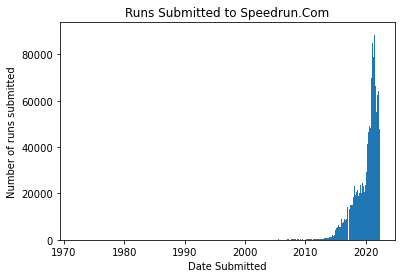

In [9]:
# Count how many runs fall in each of the cuts
counts = df['Date_Cut'].value_counts()
counts = dict(counts)
# Plot these counts
plt.bar(*zip(*counts.items()), width = 30)
plt.title('Runs Submitted to Speedrun.Com')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted')
plt.show()

Wow! This graph has several things which jump out, such as how there are somehow runs which stretch back to the 70's. We can note though how there are virtually no runs visible at this scale until 2005 or so, so let's graph from there. Speedrun.com didn't exist until 2014, so let's consider runs which were submitted from the start of that year

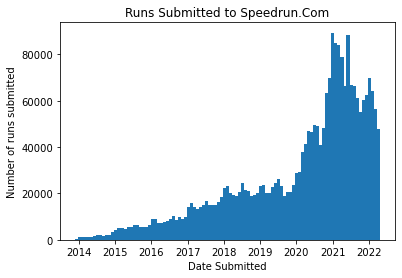

In [139]:
# Subset of more recent data
rec = df[df['Date']  >= '01-01-14']

# Count how many runs fall in each of the cuts
tot_counts = rec['Date_Cut'].value_counts()
tot_counts = dict(tot_counts)
# Plot these counts
plt.bar(*zip(*tot_counts.items()), width = 31)
plt.title('Runs Submitted to Speedrun.Com')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted')
plt.show()

We see a rather large spike in 2020, that increases so rapidly it could be exponential. We can test this theory with a graph with a logarithmic y-axis:

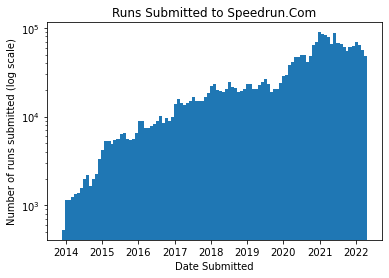

In [179]:
plt.bar(*zip(*tot_counts.items()), width = 31)
plt.title('Runs Submitted to Speedrun.Com')
plt.xlabel('Date Submitted')
plt.yscale('log')
plt.ylabel('Number of runs submitted (log scale)')
plt.show()

Look at that! We can see a nearly linear relationship with this scale, suggesting the number of runs submitted to Speedrun.com is approximately exponential. Let's do the same thing with Minecraft

At this scale, we can see an explosion in the speedrunning scene as a whole, starting gradually from 2014, slowing around 2018, before a huge and sustained spike in submitted speedruns in 2020. We can also see if this matches for Minecraft as well.

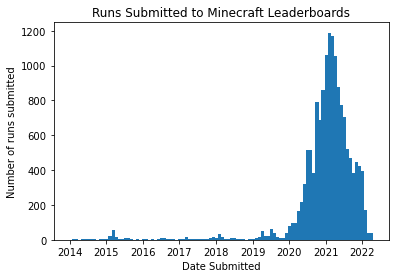

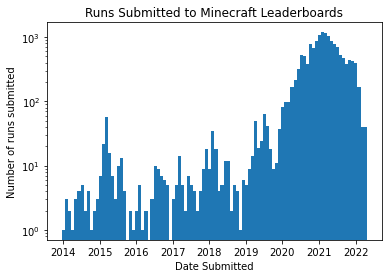

In [142]:
# All runs with game ID associated with Minecraft: JE
mine = rec[rec['Game ID'] == 'j1npme6p']

# Count how many runs fall in each of the cuts
counts = mine['Date_Cut'].value_counts()
counts = dict(counts)
# Plot these counts
plt.bar(*zip(*counts.items()), width = 31)
plt.title('Runs Submitted to Minecraft Leaderboards')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted')
plt.show()
plt.bar(*zip(*counts.items()), width = 31)
plt.title('Runs Submitted to Minecraft Leaderboards')
plt.yscale('log')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted')
plt.show()

Here we can see why people believed Minecraft speedrunning really took off after quarantine began. We see a modest number of runs continuously submitted up until 2019, then a gradual growth through 2020, then an explosion going into 2021. However the log graph shows the key differences between Minecraft and the Speedrun.com as a whole. While we could draw a general linear trend from 2013 to 2020, it appears to be quite weak. More importantly, we see a huge spike starting in 2020 and going into 2021, even on the log graph. This suggests that Minecraft surged in popularity exceedingly much, compared to its earlier years. Further, we see a sharp decline starting in 2021 and leading into 2022. These last two features differ drastically from the results in the overall Speedrun.com. This suggests that Minecraft's speedrunning popularity is different from the site as a whole, and we can show this quantitatively with linear regressions.

# Linear Regression

We can use a linear regression to make an exponential fit of the Speedrun.com data by taking the log of the number of runs per month, then fitting a linear regression with respect to time. 
First, let's copy the data we want: the months and the number of runs in those months

In [143]:
tot_freq = pd.DataFrame.from_dict([dict(tot_counts)]).melt()
tot_freq.rename(columns = {'variable': 'Month', 'value': 'Count'}, inplace = True)
# Take log
log_count = {k: math.log(v) for k, v in counts.items()}
#log_count = counts.apply(lambda x: math.log(x))
tot_freq["Count"] = tot_freq['Count'].apply(lambda x: math.log10(x))
# Change how time is represented as datetime objects don't fit well with statsmodels
copy = tot_freq['Month'].copy()
tot_freq['Month']=mdates.date2num(tot_freq['Month'])
X = tot_freq['Month']
X = sm.add_constant(X)
mod = sm.OLS(tot_freq['Count'], X)
res = mod.fit()

In [144]:
res.params

const   -5.562301
Month    0.000554
dtype: float64

In [145]:
res.summary2().tables[1]['P>|t|']

const    7.883564e-34
Month    2.025207e-54
Name: P>|t|, dtype: float64

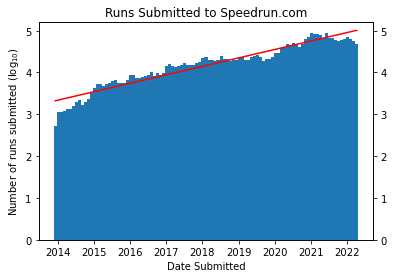

In [146]:
tot_freq['res'] = res.resid
tot_freq['fit'] = res.fittedvalues
tot_freq['Month'] = copy
tot_freq = tot_freq.sort_values(by = 'Month')
fig,ax = plt.subplots()
ax.bar(tot_freq['Month'], tot_freq['Count'], width = 31)
plt.title('Runs Submitted to Speedrun.com')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted (log$_{10}$)')
ax2 = plt.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.plot(tot_freq['Month'], tot_freq['fit'], color='r', label='Regression')
plt.show()

In [147]:
res.rsquared

0.913492334019323

In [148]:
res.mse_resid

0.023263681546275207

In [149]:
res.mse_model

24.320021315512843

In [150]:
res.ssr

2.3031044730812456

In [151]:
freq = pd.DataFrame.from_dict([dict(counts)]).melt()
freq.rename(columns = {'variable': 'Month', 'value': 'Count'}, inplace = True)
# Take log
log_count = {k: math.log(v) for k, v in counts.items()}
#log_count = counts.apply(lambda x: math.log(x))
freq["Count"] = freq['Count'].apply(lambda x: math.log10(x))
# Change how time is represented as datetime objects don't fit well with statsmodels
copy = freq['Month'].copy()
freq['Month']=mdates.date2num(freq['Month'])
X = freq['Month']
X = sm.add_constant(X)
mod = sm.OLS(freq['Count'], X)
res = mod.fit()

In [154]:
res.params

const   -13.530621
Month     0.000842
dtype: float64

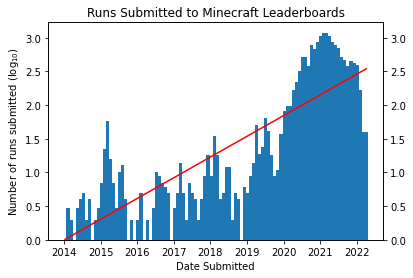

In [152]:
freq['res'] = res.resid
freq['fit'] = res.fittedvalues
freq['Month'] = copy
freq = freq.sort_values(by = 'Month')
fig,ax = plt.subplots()
plt.title('Runs Submitted to Minecraft Leaderboards')
plt.xlabel('Date Submitted')
plt.ylabel('Number of runs submitted (log$_{10}$)')
ax.bar(freq['Month'], freq['Count'], width = 31)
ax2 = plt.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.plot(freq['Month'], freq['fit'], color='r', label='Regression')
plt.show()

We see it roughly follows the data, let's look at the p-values:

In [155]:
res.summary2().tables[1]['P>|t|']

const    8.032060e-21
Month    3.208438e-23
Name: P>|t|, dtype: float64

These are miniscule, showing there is certainly a relationship between number of speedruns and time. However these values are quite different than those of the overall speedrunning community (STANDARDIZE BOTH AND COMPARE) so there must be something about minecraft affecting its results

In [156]:
res.mse_model

53.560719204703645

In [157]:
res.rsquared

0.6472904994983575

In [158]:
res.ssr

29.185310972183814

There must be another variable involved that explains Minecraft's surge and decline in runs. While quarantine obviously played a part, I suggest another variable which boosted Minecraft only until its peak: Dream. To summarize, Dream is a very popular Minecraft Youtuber who, from 2019 through 2020, was Minecraft's most popular speedrunner. However, in December of 2020 it was found that [Dream had cheated](https://mcspeedrun.com/dream.pdf) on his speedruns leading to him publically disavowing the community on Speedrun.com. We can notice how close December 2020 is to the peak we see of Minecraft speedrunning, so perhaps this could be an explantory variable. 

Dream uploaded his [first world record](https://www.youtube.com/watch?v=CFkv6DtKf3w) on March 16, 2020, and the proof of his cheating were published on December 11, 2020. Thus we can consider time between these two to be "peak dream influence." We can add whether a month occured between these two dates to our model.

In [159]:
freq['Month']=mdates.date2num(freq['Month'])
start = mdates.datestr2num('03/16/2020')
#mdates.date2num(freq['Month']) 'Mar 16, 2020'
end = mdates.datestr2num('12/11/2020')
freq['Dream'] = freq['Month'].between(start,end)
freq['Dream'] = freq['Dream'].apply(lambda x: 1 if x else 0)
freq.head()

,Month,Count,res,fit,Dream
94,16078.661157,0.000000,-0.006438,0.006438,0
76,16109.054545,0.477121,0.445095,0.032027,0
90,16139.447934,0.301030,0.243414,0.057616,0
96,16169.841322,0.000000,-0.083205,0.083205,0
80,16200.234711,0.477121,0.368327,0.108794,0


We want to add an interaction term, as we are suggesting that the growth of speedrunning with respect to time changed when dream was popular.

In [160]:
y,X = dmatrices('Count ~ Month*Dream',freq, return_type = 'dataframe')
y = np.ravel(y)
X.head()

,Intercept,Month,Dream,Month:Dream
94,1.0,16078.661157,0.0,0.0
76,1.0,16109.054545,0.0,0.0
90,1.0,16139.447934,0.0,0.0
96,1.0,16169.841322,0.0,0.0
80,1.0,16200.234711,0.0,0.0


Now we fit the model

In [161]:
mod = sm.OLS(y,X)
fit = mod.fit()

In [162]:
fit.params

Intercept     -12.196165
Month           0.000762
Dream         -35.893774
Month:Dream     0.001983
dtype: float64

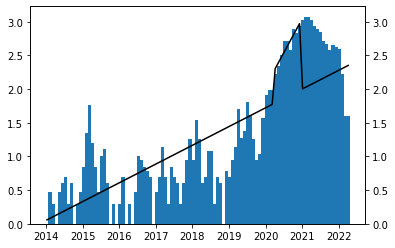

In [166]:
freq['res'] = fit.resid
freq['fit'] = fit.fittedvalues
freq['Month'] = copy
freq = freq.sort_values(by = 'Month')
fig,ax = plt.subplots()
ax.bar(freq['Month'], freq['Count'], width = 31)
ax2 = plt.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.plot(freq['Month'], freq['fit'], color='k', label='Regression')
plt.show()

In [167]:
fit.summary2().tables[1]['P>|t|']

Intercept      1.069543e-18
Month          6.716696e-21
Dream          3.788544e-01
Month:Dream    3.690292e-01
Name: P>|t|, dtype: float64

These p-values suggest the dream sweetspot is significant! but what if we also added the 5 month period before Dream admitted to cheating?This is the period after he was caught cheating, before he [admitted to it](https://www.looper.com/432321/dreams-minecraft-speedrun-cheating-scandal-explained/) on May 30, 2021.

Let's also plot the residuals

In [169]:
#We see

In [170]:
freq['Month']=mdates.date2num(freq['Month'])
very_end = mdates.datestr2num('05/30/2021')
freq['Cheat'] = freq['Month'].apply(lambda x: 1 if x > end else 0)
#freq['Cheat'] = freq['Cheat'].apply(lambda x: 1 if x else 0)
freq.head()

,Month,Count,res,fit,Dream,Cheat
94,16078.661157,0.000000,-0.058446,0.058446,0,0
76,16109.054545,0.477121,0.395511,0.081610,0,0
90,16139.447934,0.301030,0.196255,0.104775,0,0
96,16169.841322,0.000000,-0.127940,0.127940,0,0
80,16200.234711,0.477121,0.326016,0.151105,0,0


In [171]:
y,X = dmatrices('Count ~ Month*Dream + Month*Cheat',freq, return_type = 'dataframe')
y = np.ravel(y)
mod = sm.OLS(y,X)
fit = mod.fit()

In [172]:
fit.params

Intercept      -6.464687
Month           0.000423
Dream         -41.625253
Month:Dream     0.002322
Cheat          61.912920
Month:Cheat    -0.003224
dtype: float64

In [173]:
fit.summary2().tables[1]['P>|t|']

Intercept      2.191631e-07
Month          9.302297e-09
Dream          1.660017e-01
Month:Dream    1.535356e-01
Cheat          5.530645e-06
Month:Cheat    7.928875e-06
Name: P>|t|, dtype: float64

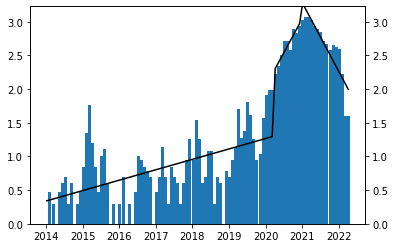

In [174]:
freq['res'] = fit.resid
freq['fit'] = fit.fittedvalues
freq['Month'] = copy
freq = freq.sort_values(by = 'Month')
fig,ax = plt.subplots()
ax.bar(freq['Month'], freq['Count'], width = 30)
ax2 = plt.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.plot(freq['Month'], freq['fit'], color='k', label='Regression')
plt.show()

In [36]:
freq

,Month,Count,res,fit,Dream,Cheat
78,2013-02-08 08:00:47.603305728,1.098612,0.629268,0.469344,0,0
83,2013-03-10 17:27:16.363636480,1.098612,0.599834,0.498778,0,0
88,2013-04-10 02:53:45.123966976,0.693147,0.164936,0.528211,0,0
76,2013-05-10 12:20:13.884297472,1.098612,0.540967,0.557645,0,0
103,2013-06-09 21:46:42.644627968,0.000000,-0.587078,0.587078,0,0
...,...,...,...,...,...,...
15,2021-12-05 00:47:36.198347008,6.049733,0.669827,5.379907,0,1
16,2022-01-04 10:14:04.958677760,5.973810,0.789882,5.183928,0,1
21,2022-02-03 19:40:33.719008256,5.129899,0.141950,4.987949,0,1
31,2022-03-06 05:07:02.479338752,3.688879,-1.103091,4.791970,0,1


In [37]:
copy

0     2021-02-04 02:22:48.595041280
1     2021-03-06 11:49:17.355371776
2     2021-01-04 16:56:19.834710784
3     2021-04-05 21:15:46.115702528
4     2021-05-06 06:42:14.876033024
                   ...             
100   2015-12-08 17:01:05.454545408
101   2016-03-08 21:20:31.735537152
102   2014-04-09 20:11:30.247933952
103   2013-06-09 21:46:42.644627968
104   2013-12-09 06:25:35.206611456
Name: Month, Length: 105, dtype: datetime64[ns]

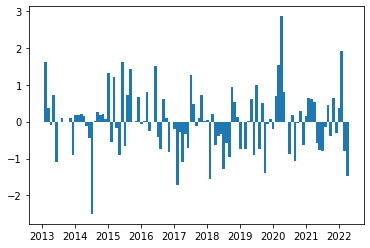

In [38]:
freq['res'] = fit.resid
fig,ax = plt.subplots()
ax.bar(copy, freq['res'], width = 30)
plt.show()

In [39]:
freq

,Month,Count,res,fit,Dream,Cheat
78,2013-02-08 08:00:47.603305728,1.098612,0.629268,0.469344,0,0
83,2013-03-10 17:27:16.363636480,1.098612,0.599834,0.498778,0,0
88,2013-04-10 02:53:45.123966976,0.693147,0.164936,0.528211,0,0
76,2013-05-10 12:20:13.884297472,1.098612,0.540967,0.557645,0,0
103,2013-06-09 21:46:42.644627968,0.000000,-0.587078,0.587078,0,0
...,...,...,...,...,...,...
15,2021-12-05 00:47:36.198347008,6.049733,0.669827,5.379907,0,1
16,2022-01-04 10:14:04.958677760,5.973810,0.789882,5.183928,0,1
21,2022-02-03 19:40:33.719008256,5.129899,0.141950,4.987949,0,1
31,2022-03-06 05:07:02.479338752,3.688879,-1.103091,4.791970,0,1


However, unlike the general trend we saw before, Minecraft exceeded in popularity, even on the logarithmic scale. Weirder, we see a steep dropoff starting in 2021. This suggests Minecraft's speedrunning popularity may be different to the overall speedrunning scene. Let's investigate with a linear model. 

So we see time plays an important factor here, but to what extent? Well, let's attempt a linear regression. Let's first begin with Minecraft, and can generalize for all the other games later. These are the variables I will immediately consider: the date submitted, the category, the variables (aka the subcategory), and if the date is after March 1, 2020 (meaning the runner would likely be living in quarantine and/or a pandemic). 